# **Hardware and Software for Big Data Mod B**

### Prof. Flora Amato

*   Rabia Simal Capar
*   Hawzhin Tohidi
*   Mohammad Ehsani



## Data Uploading and Preparation

**Install required libraries and then import**

---



In [1]:
# Install necessary libraries
!pip install pyspark matplotlib scikit-learn statsmodels missingno

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f2d244bb9c281fb71a0699d78df83ab5a8abae4f121b5bb8a1c49604edb9cf5f
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


Since our dataset is too large to process with the Pandas library, we prefer to work with PySpark mostly.

In [2]:
# Import necessary libraries
from pyspark.sql import SparkSession
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import when, col, avg, count
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

# Initialize Spark session
spark = SparkSession.builder \
    .appName("TimeSeriesAnalysis") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

**Mount on Google Drive**

---



In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


**Load the CSV files**

---



In [4]:
# Define the path to your Google Drive directory
base_path = '/content/drive/My Drive/Big_Data/final_project/'

# List of CSV files
csv_files = [
    'courses.csv',
    'assessments.csv',
    'studentAssessment.csv',
    'studentInfo.csv',
    'studentRegistration.csv',
    'studentVle.csv',
    'vle.csv'
]

**Load CSV files into Spark DataFrames**

---



In [5]:
dfs = {file: spark.read.csv(base_path + file, header=True, inferSchema=True) for file in csv_files}

Let's inspect and merge the DataFrames because we have 7 different CSV files in the data file. They should be merged via key columns and one final dataset has to be prepared for further analysis.

In [6]:
# Display first few rows of each DataFrame
for file, df in dfs.items():
    print(f"First few rows of {file}:")
    df.show(5)

First few rows of courses.csv:
+-----------+-----------------+--------------------------+
|code_module|code_presentation|module_presentation_length|
+-----------+-----------------+--------------------------+
|        AAA|            2013J|                       268|
|        AAA|            2014J|                       269|
|        BBB|            2013J|                       268|
|        BBB|            2014J|                       262|
|        BBB|            2013B|                       240|
+-----------+-----------------+--------------------------+
only showing top 5 rows

First few rows of assessments.csv:
+-----------+-----------------+-------------+---------------+----+------+
|code_module|code_presentation|id_assessment|assessment_type|date|weight|
+-----------+-----------------+-------------+---------------+----+------+
|        AAA|            2013J|         1752|            TMA|  19|  10.0|
|        AAA|            2013J|         1753|            TMA|  54|  20.0|
|       

**Merging DataFrames**

---



In [7]:
# Merge studentRegistration with studentInfo
merged_df = dfs['studentRegistration.csv'].join(
    dfs['studentInfo.csv'],
    on=['code_module', 'code_presentation', 'id_student'],
    how='inner'
)

# Merge the result with studentAssessment
merged_df = merged_df.join(
    dfs['studentAssessment.csv'],
    on=['id_student'],
    how='inner'
)

# Merge the result with assessments
merged_df = merged_df.join(
    dfs['assessments.csv'],
    on=['id_assessment', 'code_module', 'code_presentation'],
    how='inner'
)

# Merge the result with courses
merged_df = merged_df.join(
    dfs['courses.csv'],
    on=['code_module', 'code_presentation'],
    how='inner'
)

# Merge the result with vle
merged_df = merged_df.join(
    dfs['vle.csv'],
    on=['code_module', 'code_presentation'],
    how='inner'
)

Print the merged DataFrame

In [8]:
merged_df.printSchema()
merged_df.show(5)

root
 |-- code_module: string (nullable = true)
 |-- code_presentation: string (nullable = true)
 |-- id_assessment: integer (nullable = true)
 |-- id_student: integer (nullable = true)
 |-- date_registration: integer (nullable = true)
 |-- date_unregistration: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- region: string (nullable = true)
 |-- highest_education: string (nullable = true)
 |-- imd_band: string (nullable = true)
 |-- age_band: string (nullable = true)
 |-- num_of_prev_attempts: integer (nullable = true)
 |-- studied_credits: integer (nullable = true)
 |-- disability: string (nullable = true)
 |-- final_result: string (nullable = true)
 |-- date_submitted: integer (nullable = true)
 |-- is_banked: integer (nullable = true)
 |-- score: integer (nullable = true)
 |-- assessment_type: string (nullable = true)
 |-- date: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- module_presentation_length: integer (nullable = true)
 |-- id_site

## Data Pre-Processing

Now, the data has to be cleaned, which means the missing values should be handled with appropriate strategies.



**Handling missing values**


---



In [9]:
# Check for missing values in each column and calculate the percentage of missing values
from pyspark.sql.functions import col, sum as spark_sum, round

In [10]:
# Calculate the total number of rows in the DataFrame
total_rows = merged_df.count()

In [11]:
# Calculate the number of missing values in each column
missing_values = merged_df.select(
    [(total_rows - spark_sum(col(c).isNotNull().cast("int"))).alias(c) for c in merged_df.columns]
).toPandas()

In [12]:
# Calculate the percentage of missing values for each column
percentage_missing = (missing_values / total_rows) * 100

Displaying missing values in a table

In [13]:
missing_values_transposed = missing_values.T
missing_values_transposed.columns = ['Missing Values']
percentage_missing_transposed = percentage_missing.T
percentage_missing_transposed.columns = ['Percentage Missing']

missing_df = missing_values_transposed.join(percentage_missing_transposed)
missing_df

,Missing Values,Percentage Missing
code_module,0,0.000000
code_presentation,0,0.000000
id_assessment,0,0.000000
id_student,0,0.000000
date_registration,2521,0.004180
date_unregistration,55695628,92.347557
gender,0,0.000000
region,0,0.000000
highest_education,0,0.000000
imd_band,2955496,4.900436


Since the missing value ratio in week_from and week_to columns are so huge and since they will not provide us any insightful information for our score prediction, we basically remove these two columns.

In [14]:
# Remove columns 'week_from' and 'week_to'
columns_to_remove = ['week_from', 'week_to']
merged_df = merged_df.drop(*columns_to_remove)

Our dataset contains around 60 million rows, therefore we may basically remove the rows with missing values. No significant information would be lost this way.

In [15]:
# Remove rows with missing values in specific columns
columns_to_check = ['date', 'score', 'imd_band', 'date_registration']
merged_df = merged_df.dropna(subset=columns_to_check)

In [16]:
# Verify if there are still missing values in the specified columns
missing_values_after = merged_df.select(
    [spark_sum(col(c).isNull().cast("int")).alias(c) for c in columns_to_check]
).toPandas()

print("Missing values after preprocessing in the specified columns:")
print(missing_values_after)

Missing values after preprocessing in the specified columns:
   date  score  imd_band  date_registration
0     0      0         0                  0


It seems everything worked well till now, there are no more missing values in the main dataframe.

In [17]:
merged_df.show()

+-----------+-----------------+-------------+----------+-----------------+-------------------+------+-------------------+-----------------+--------+--------+--------------------+---------------+----------+------------+--------------+---------+-----+---------------+----+------+--------------------------+-------+-------------+
|code_module|code_presentation|id_assessment|id_student|date_registration|date_unregistration|gender|             region|highest_education|imd_band|age_band|num_of_prev_attempts|studied_credits|disability|final_result|date_submitted|is_banked|score|assessment_type|date|weight|module_presentation_length|id_site|activity_type|
+-----------+-----------------+-------------+----------+-----------------+-------------------+------+-------------------+-----------------+--------+--------+--------------------+---------------+----------+------------+--------------+---------+-----+---------------+----+------+--------------------------+-------+-------------+
|        AAA|      

## Visualisation

Visualising our predictors may provide insightful conclusions about their relations with the target variable 'score'.

Selecting columns to visualise some predictors

In [18]:
visual_data = merged_df.select('score', 'gender','region','highest_education','final_result',
                                  'assessment_type','studied_credits','age_band','date_registration',
                                  'disability','weight','module_presentation_length','activity_type','imd_band','age_band')

Since our merged dataset is too large and pandas cannot handle it, we use a smaller fraction of it, and then visualise the features.

In [19]:
sample_visual_dat = visual_data.sample(withReplacement=False, fraction=0.02, seed=42)

Converting the spark df to pandas would be more useful so that we may benefit from the Matplotlib library.

In [20]:
panda_df = sample_visual_dat.toPandas()

In [21]:
panda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131798 entries, 0 to 1131797
Data columns (total 15 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   score                       1131798 non-null  int32  
 1   gender                      1131798 non-null  object 
 2   region                      1131798 non-null  object 
 3   highest_education           1131798 non-null  object 
 4   final_result                1131798 non-null  object 
 5   assessment_type             1131798 non-null  object 
 6   studied_credits             1131798 non-null  int32  
 7   age_band                    1131798 non-null  object 
 8   date_registration           1131798 non-null  int32  
 9   disability                  1131798 non-null  object 
 10  weight                      1131798 non-null  float64
 11  module_presentation_length  1131798 non-null  int32  
 12  activity_type               1131798 non-null  object 
 1

**Correlation HeatMap**

---



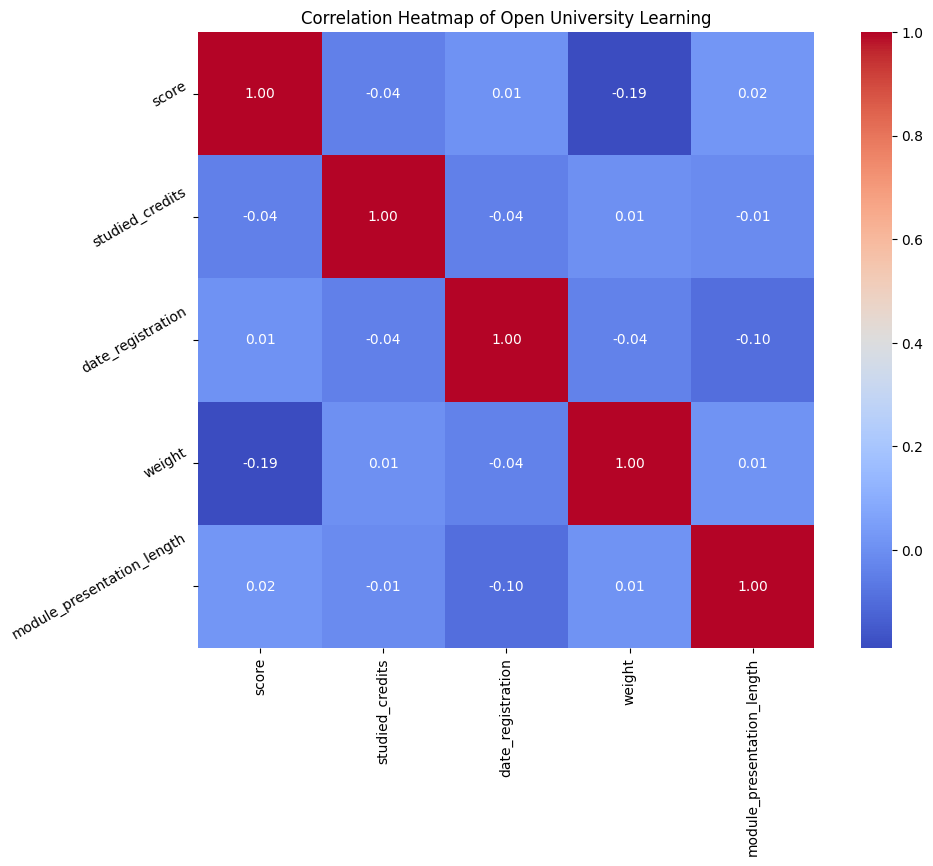

In [22]:
correlation = panda_df.select_dtypes(include=['float64', 'int32']).corr()

plt.figure(figsize=(12, 8))
plt.title('Correlation Heatmap of Open University Learning')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white', cmap='coolwarm')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
plt.show()

The correlation heatmap shows the relationships between numerical variables, highlighting how they relate to the score. Obviously, there exists no significant linear correlation between numerical variables.

**The Barchart of Genders**

---



Text(0.5, 1.0, 'The Barchart of Genders')

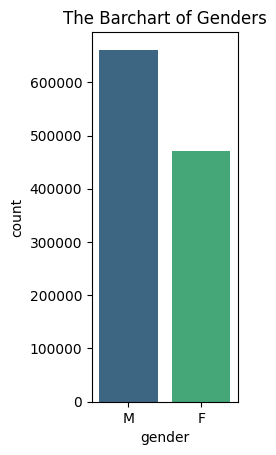

In [23]:
plt.subplot(1, 3, 1)
sns.countplot(data=panda_df, x='gender', palette='viridis')
plt.title('The Barchart of Genders')

**The Barchart of Age Band**

---



Text(0.5, 1.0, 'The Barchart of Age Band')

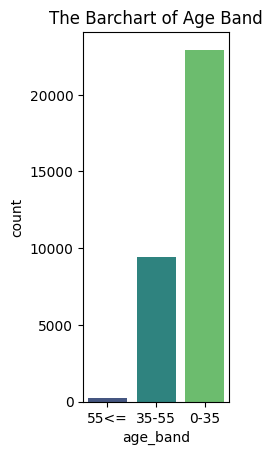

In [24]:
age_csv = pd.read_csv('/content/drive/My Drive/Big_Data/final_project/studentInfo.csv')
plt.subplot(1, 3, 2)
sns.countplot(data=age_csv, x='age_band', palette='viridis')
plt.title('The Barchart of Age Band')

**The Barchart of Regions**

---



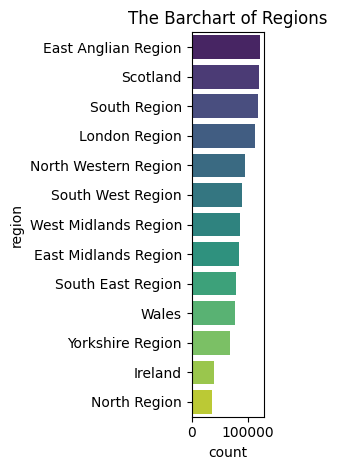

In [25]:
plt.subplot(1, 3, 3)
sns.countplot(data=panda_df, y='region', palette='viridis', order=panda_df['region'].value_counts().index)
plt.title('The Barchart of Regions')

# Show the plots
plt.tight_layout()
plt.show()

**The Barchart of final results by highest education level**

---



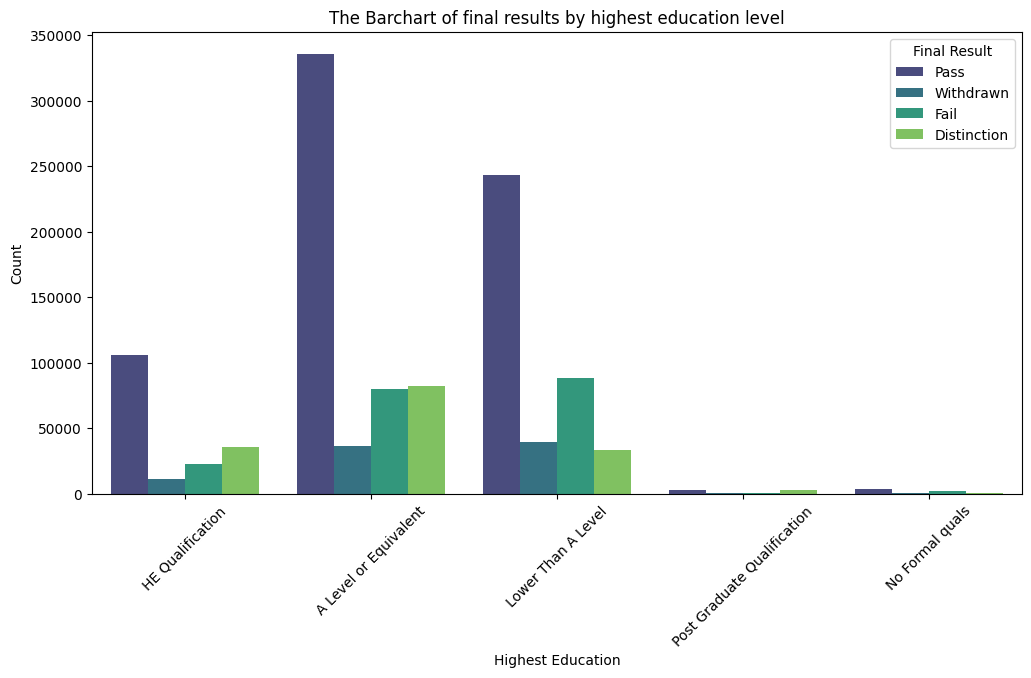

In [26]:
plt.figure(figsize=(12, 6))
sns.countplot(data=panda_df, x='highest_education', hue='final_result', palette='viridis')
plt.title('The Barchart of final results by highest education level')
plt.xlabel('Highest Education')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Final Result')
plt.show()

**The Distribution of assessment scores**

---



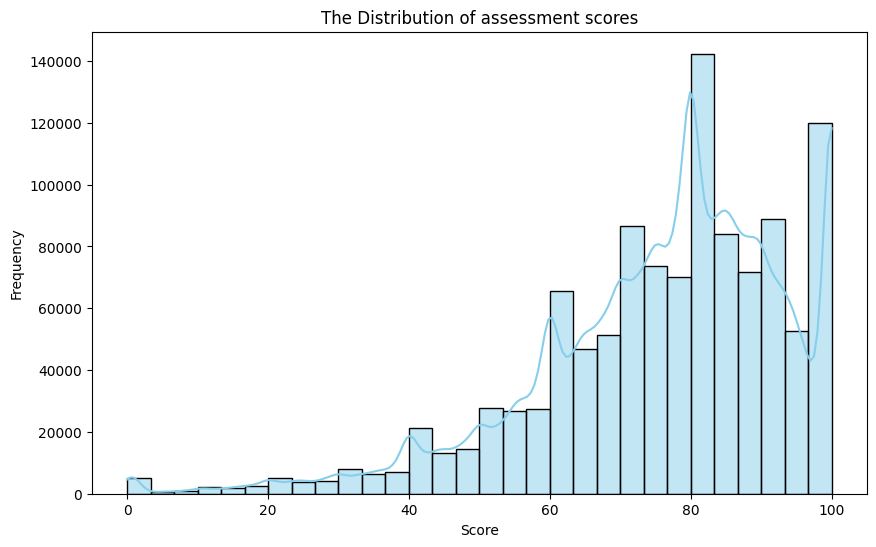

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data=panda_df, x='score', bins=30, kde=True, color='skyblue')
plt.title('The Distribution of assessment scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

**Scatter Plots for Numerical Variables**

---



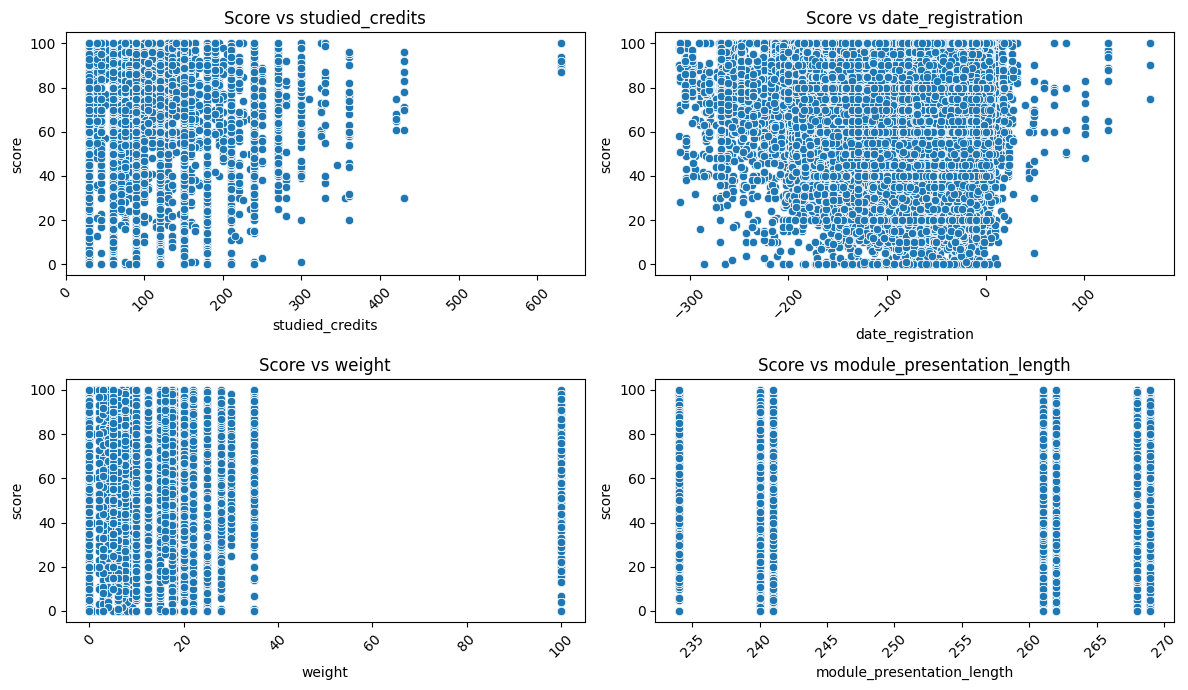

In [28]:
numerical_vars = ['studied_credits', 'date_registration', 'weight', 'module_presentation_length']
plt.figure(figsize=(12, 7))
for i, var in enumerate(numerical_vars, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=var, y='score', data=panda_df)
    plt.title(f'Score vs {var}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The scatter plots provide insight into how the score varies with different numerical variables. When we look at each plot, it can be concluded that the numerical variables in our dataset don't have an insightful relation with our target variable 'score'. Therefore, we are going to ignore numerical variables in our analysis.

In [29]:
# Select the numerical columns which are going to be removed
columns_to_drop = ["studied_credits", "weight", "module_presentation_length", "date_registration"]

# Drop the specified columns
merged_df = merged_df.drop(*columns_to_drop)

## Feature Engineering





We are going to encode some categorical variables, so that they become useable if they have significant relations with the target variable 'score'.

**Date Unregistration:**

---



It would be better if we encode the date_unregistered column as "1" if there exist any value, but as "0" if the value is missing.

In [30]:
# Create a new column 'unregistered' with 1 if 'date_unregistration' has a value, otherwise 0
merged_df = merged_df.withColumn('unregistered', when(col('date_unregistration').isNotNull(), 1).otherwise(0))

In [31]:
merged_df.select('date_unregistration', 'unregistered').show(5)

+-------------------+------------+
|date_unregistration|unregistered|
+-------------------+------------+
|               NULL|           0|
|               NULL|           0|
|               NULL|           0|
|               NULL|           0|
|               NULL|           0|
+-------------------+------------+
only showing top 5 rows



We should now remove the date_unregistration column since we already encoded the values, and the orijinal column has many missing values.

In [32]:
# Drop the 'date_unregistration' column
merged_df = merged_df.drop('date_unregistration')

**Gender:**

---



Calculate the Percentage of M and F

In [33]:
# Calculate the count of each gender
gender_counts = merged_df.groupBy('gender').count()

# Calculate the total number of rows
total_count = merged_df.count()

# Calculate the percentage
gender_percentage = gender_counts.withColumn('percentage', (gender_counts['count'] / total_count) * 100)

gender_percentage.show()

+------+--------+-----------------+
|gender|   count|       percentage|
+------+--------+-----------------+
|     F|23496186| 41.5193069256893|
|     M|33094802|58.48069307431069|
+------+--------+-----------------+



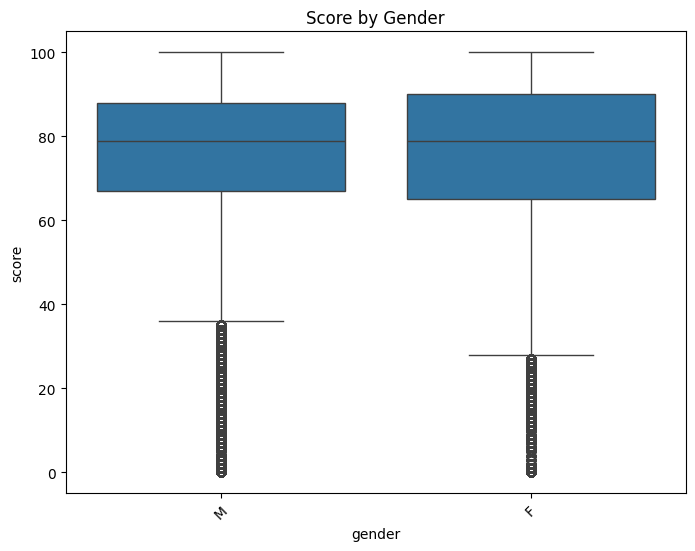

In [34]:
# Box Plot for gender
plt.figure(figsize=(8, 6))
sns.boxplot(x='gender', y='score', data=panda_df)
plt.title('Score by Gender')
plt.xticks(rotation=45)
plt.show()

As we observe from the boxplot, the distribution of two genders in the dataset is almost the same. Both their median and mean values are very close to each other, therefore it will not contribute to our target variable prediction 'score'. It is better to remove the gender column so that the dimension of our dataset is minimized.

In [35]:
# Drop the 'gender' column
merged_df = merged_df.drop('gender')

**Region:**

---



Calculate the percentage of each region

In [36]:
# Calculate the count of each region
region_counts = merged_df.groupBy('region').count()

region_counts.show()

+--------------------+-------+
|              region|  count|
+--------------------+-------+
| East Anglian Region|6135255|
|   South West Region|4492198|
|               Wales|3864629|
|West Midlands Region|4314352|
|   South East Region|4003092|
|North Western Region|4809277|
|East Midlands Region|4190188|
|             Ireland|1978146|
|    Yorkshire Region|3442473|
|        North Region|1795781|
|       London Region|5595825|
|        South Region|5942126|
|            Scotland|6027646|
+--------------------+-------+



In [37]:
# Calculate the total number of rows
total_count = merged_df.count()

# Calculate the percentage of each region
region_percentage = region_counts.withColumn('percentage', (col('count') / total_count) * 100)

region_percentage.show()

+--------------------+-------+------------------+
|              region|  count|        percentage|
+--------------------+-------+------------------+
| East Anglian Region|6135255|10.841399340827907|
|   South West Region|4492198| 7.938009493667083|
|               Wales|3864629| 6.829053770893697|
|West Midlands Region|4314352| 7.623743907775562|
|   South East Region|4003092|7.0737270040240325|
|North Western Region|4809277| 8.498308953361972|
|East Midlands Region|4190188| 7.404337948650057|
|             Ireland|1978146| 3.495514162078245|
|    Yorkshire Region|3442473| 6.083076337172272|
|        North Region|1795781|3.1732632057952412|
|       London Region|5595825|  9.88819103140592|
|        South Region|5942126|10.500127688175368|
|            Scotland|6027646| 10.65124715617264|
+--------------------+-------+------------------+



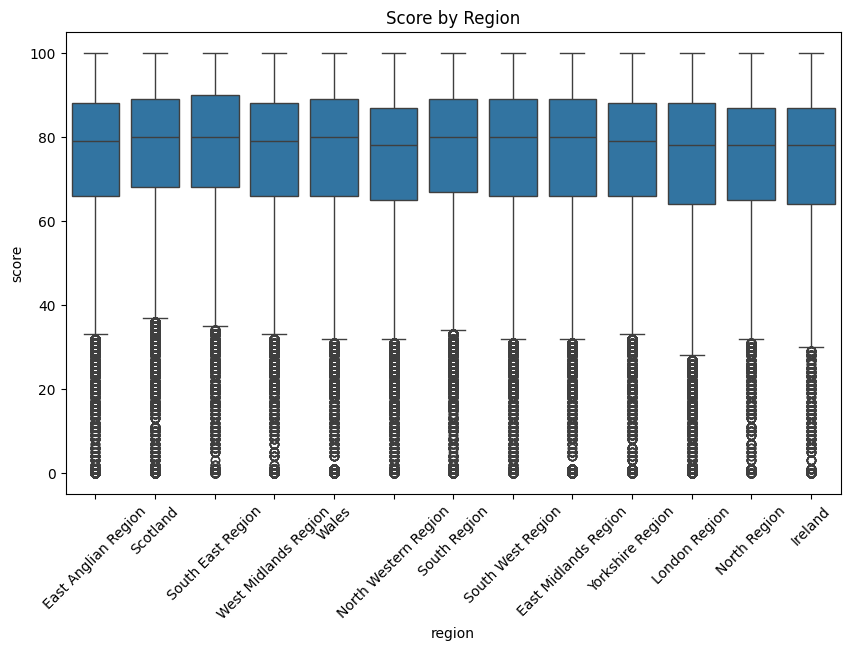

In [38]:
# Box Plot for region
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='score', data=panda_df)
plt.title('Score by Region')
plt.xticks(rotation=45)
plt.show()

We observe a very similar case again, the one with the gender variable. The score distribution of students coming from different regions do not differ from each other in a significant way. Therefore, we can basically remove the region category as well.

In [39]:
# Drop the 'region' column
merged_df = merged_df.drop('region')

**Highest Education:**

---



Calculate the percentage of each education level

In [40]:
# Calculate the count of each highest_education category
highest_education_counts = merged_df.groupBy('highest_education').count()

highest_education_counts.show()

+--------------------+--------+
|   highest_education|   count|
+--------------------+--------+
|A Level or Equiva...|26782988|
|  Lower Than A Level|20248998|
|     No Formal quals|  389901|
|Post Graduate Qua...|  360369|
|    HE Qualification| 8808732|
+--------------------+--------+



In [41]:
# Calculate the total number of rows
total_count = merged_df.count()

# Calculate the percentage of each highest_education category
highest_education_percentage = highest_education_counts.withColumn('percentage', (col('count') / total_count) * 100)

highest_education_percentage.show()

+--------------------+--------+------------------+
|   highest_education|   count|        percentage|
+--------------------+--------+------------------+
|A Level or Equiva...|26782988| 47.32730236128763|
|  Lower Than A Level|20248998|35.781312035054064|
|     No Formal quals|  389901|0.6889807260477587|
|Post Graduate Qua...|  360369|0.6367957385723677|
|    HE Qualification| 8808732| 15.56560913903818|
+--------------------+--------+------------------+



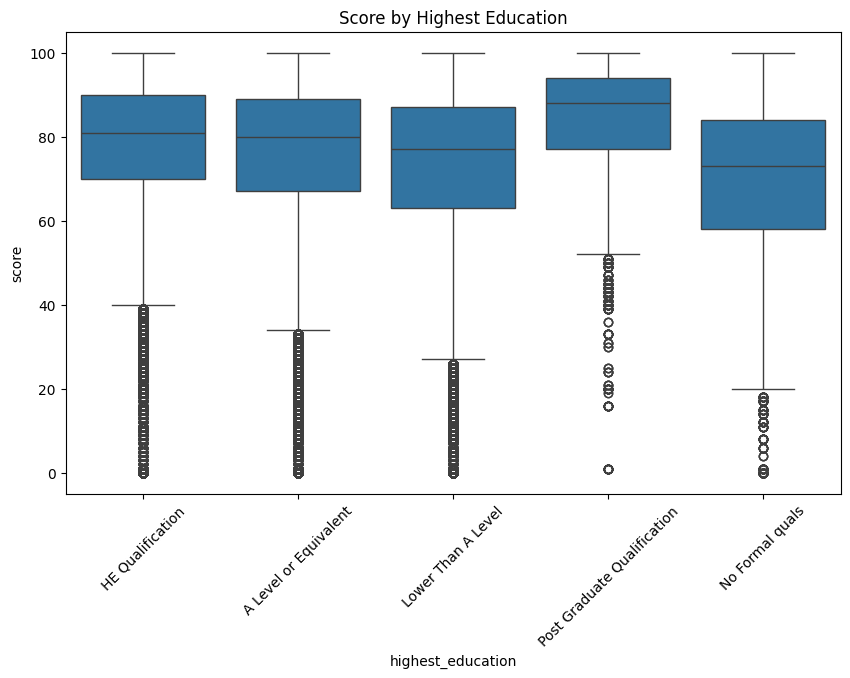

In [42]:
# Box Plot for highest_education
plt.figure(figsize=(10, 6))
sns.boxplot(x='highest_education', y='score', data=panda_df)
plt.title('Score by Highest Education')
plt.xticks(rotation=45)
plt.show()

It seems that the people of the category 'Post Graduate Qualification' have significantly higher score distribution compared with the people in other categories. This means, we can divide the highest education category in two levels: 'Post Graduate Qualification' and 'Others'. This will be our encoding startegy for the education category. Others will be encoded as 0 and Post Graduate Qualification will be encoded as 1.

In [43]:
merged_df = merged_df.withColumn('highest_education_encoded', when(col('highest_education') == 'HE Qualification', 0).when(col('highest_education') == 'Post Graduate Qualification', 1).when(col('highest_education') == 'Lower Than A Level', 0).when(col('highest_education') == 'No Formal quals', 0).when(col('highest_education') == 'A Level or Equivalent', 0).otherwise(None))

merged_df.select('highest_education', 'highest_education_encoded').show(5)

+-----------------+-------------------------+
|highest_education|highest_education_encoded|
+-----------------+-------------------------+
| HE Qualification|                        0|
| HE Qualification|                        0|
| HE Qualification|                        0|
| HE Qualification|                        0|
| HE Qualification|                        0|
+-----------------+-------------------------+
only showing top 5 rows



In [44]:
# Drop the 'highest_education' column
merged_df = merged_df.drop('highest_education')

**Imd Band:**

---



Calculate the percentage of each imd level

In [45]:
# Calculate the count of each imd_band category
imd_band_counts = merged_df.groupBy('imd_band').count()

imd_band_counts.show()

+--------+-------+
|imd_band|  count|
+--------+-------+
|  60-70%|5407311|
|  70-80%|5574209|
|  30-40%|6653601|
|  40-50%|5737226|
|  80-90%|5402676|
|  20-30%|5957795|
|   10-20|5691724|
| 90-100%|5243188|
|  50-60%|5762448|
|   0-10%|5160810|
+--------+-------+



In [46]:
# Calculate the total number of rows
total_count = merged_df.count()

# Calculate the percentage of each imd_band category
imd_band_percentage = imd_band_counts.withColumn('percentage', (col('count') / total_count) * 100)

imd_band_percentage.show()

+--------+-------+------------------+
|imd_band|  count|        percentage|
+--------+-------+------------------+
|  60-70%|5407311| 9.555074387462541|
|  70-80%|5574209| 9.849994136875646|
|  30-40%|6653601|11.757350834730081|
|  40-50%|5737226|10.138055903883494|
|  80-90%|5402676| 9.546884037437199|
|  20-30%|5957795|10.527815842338713|
|   10-20|5691724| 10.05765087543621|
| 90-100%|5243188| 9.265058245669787|
|  50-60%|5762448|10.182624837721512|
|   0-10%|5160810|  9.11949089844482|
+--------+-------+------------------+



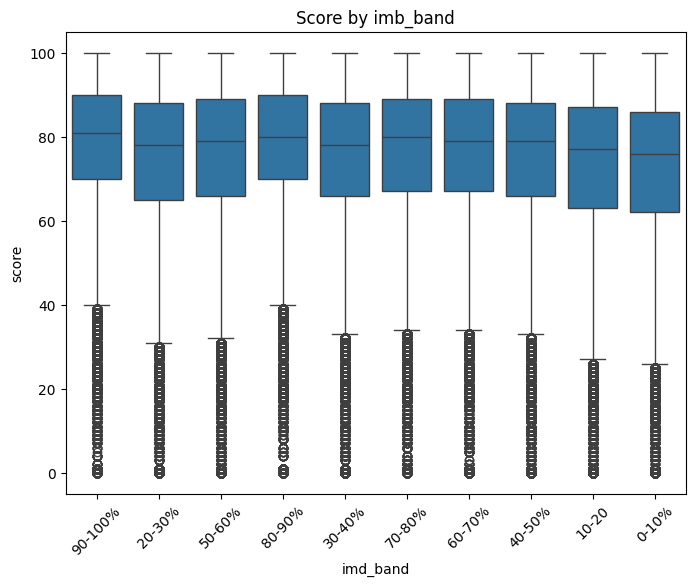

In [47]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='imd_band', y='score', data=panda_df)
plt.title('Score by imb_band')
plt.xticks(rotation=45)
plt.show()

From the boxplot of Imd Bands we can infer that imd band categories also do not contribute to the prediction of scores, since their distribution are almost similar with each other. Therefore, we are going to remove this category from our dataset as we did for the gender and region.

In [48]:
# Drop the 'imd_band' column
merged_df = merged_df.drop('imd_band')

**Age Band:**

---



Calculate the percentage of each age category.

In [49]:
# Calculate the count of each age_band category
age_band_counts = merged_df.groupBy('age_band').count()

age_band_counts.show()

+--------+--------+
|age_band|   count|
+--------+--------+
|    0-35|39788806|
|    55<=|  347744|
|   35-55|16454438|
+--------+--------+



In [50]:
# Calculate the total number of rows
total_count = merged_df.count()

# Calculate the percentage of each age_band category
age_band_percentage = age_band_counts.withColumn('percentage', (col('count') / total_count) * 100)

age_band_percentage.show()

+--------+--------+------------------+
|age_band|   count|        percentage|
+--------+--------+------------------+
|    0-35|39788806| 70.30943866892729|
|    55<=|  347744|0.6144865327320315|
|   35-55|16454438|29.076074798340684|
+--------+--------+------------------+



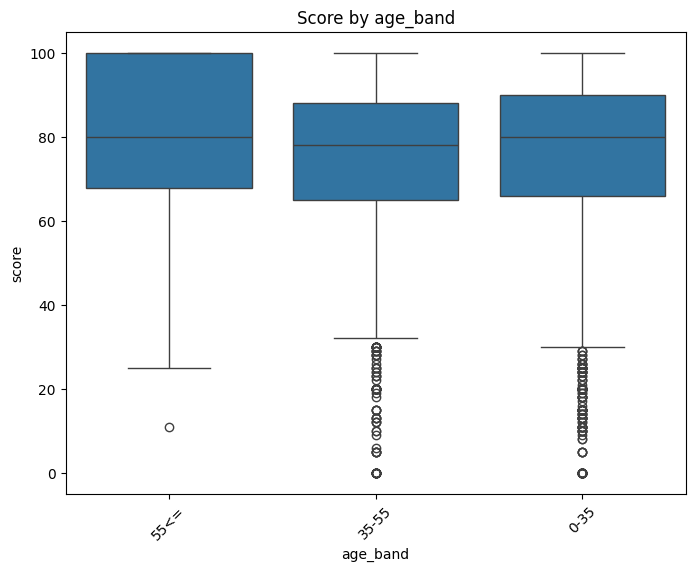

In [51]:
studentScore_csv = pd.read_csv('/content/drive/My Drive/Big_Data/final_project/studentAssessment.csv')
plt.figure(figsize=(8, 6))
sns.boxplot(x=age_csv['age_band'], y=studentScore_csv['score'])
plt.title('Score by age_band')
plt.xticks(rotation=45)
plt.show()

It is apparent from the boxplot of the age bands that the people older than 55 years can get higher scores compared with young people. Therefore we can reduce these 3 categories into 2 such as "55<=" and "others", also encode them as 1 and 0 respectively.

In [52]:
# Create a new column 'age_band_encoded' with the specified categories
merged_df = merged_df.withColumn(
    'age_band_encoded',
    when(col('age_band') == '55<=', 1)
    .when((col('age_band') == '35-55') | (col('age_band') == '0-35'), 0)
    .otherwise(None)
)

merged_df.select('age_band', 'age_band_encoded').show(10)

+--------+----------------+
|age_band|age_band_encoded|
+--------+----------------+
|    55<=|               1|
|    55<=|               1|
|    55<=|               1|
|    55<=|               1|
|    55<=|               1|
|    55<=|               1|
|    55<=|               1|
|    55<=|               1|
|    55<=|               1|
|    55<=|               1|
+--------+----------------+
only showing top 10 rows



In [53]:
# Drop the 'age_band' column
merged_df = merged_df.drop('age_band')

**Disability:**

---



Calculate the percentage of disability categories.

In [54]:
# Calculate the count of each disability category
disability_counts = merged_df.groupBy('disability').count()

disability_counts.show()

# Calculate the total number of rows
total_count = merged_df.count()

+----------+--------+
|disability|   count|
+----------+--------+
|         Y| 5060615|
|         N|51530373|
+----------+--------+



In [55]:
disability_percentage = disability_counts.withColumn('percentage', (col('count') / total_count) * 100)

disability_percentage.show()

+----------+--------+-----------------+
|disability|   count|       percentage|
+----------+--------+-----------------+
|         Y| 5060615|8.942439739698484|
|         N|51530373|91.05756026030151|
+----------+--------+-----------------+



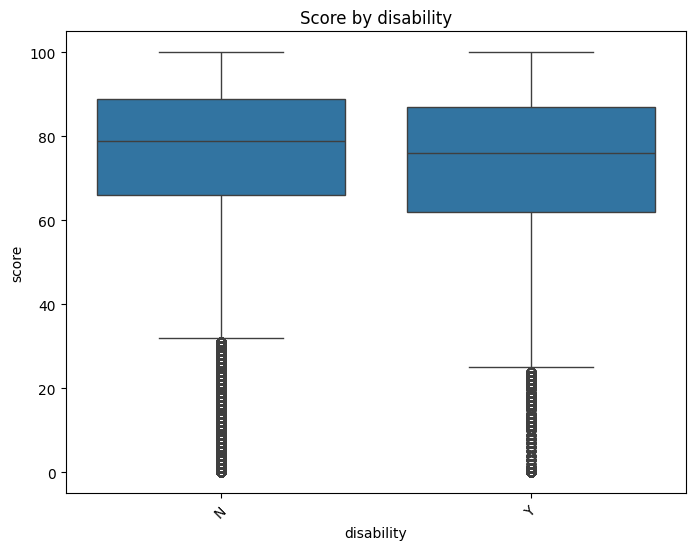

In [56]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='disability', y='score', data=panda_df)
plt.title('Score by disability')
plt.xticks(rotation=45)
plt.show()

As in the case of the gender variable, both disabled and undisabled people have similar median scores and similar score distributions. Therefore we cannot account the disability variable in our score analysis. It's better to remove the column.

In [57]:
# Drop the 'disability' column
merged_df = merged_df.drop('disability')

**Final Result:**

---



Calculate the percentage of final result categories.

In [58]:
# Calculate the count of each final_result category
final_result_counts = merged_df.groupBy('final_result').count()

final_result_counts.show()

# Calculate the total number of rows
total_count = merged_df.count()

+------------+--------+
|final_result|   count|
+------------+--------+
|        Fail| 9662779|
| Distinction| 7803142|
|   Withdrawn| 4451252|
|        Pass|34673815|
+------------+--------+



In [59]:
final_result_percentage = final_result_counts.withColumn('percentage', (col('count') / total_count) * 100)

final_result_percentage.show()

+------------+--------+------------------+
|final_result|   count|        percentage|
+------------+--------+------------------+
|        Fail| 9662779|17.074766392132968|
| Distinction| 7803142|13.788665432029568|
|   Withdrawn| 4451252|7.8656552170462195|
|        Pass|34673815| 61.27091295879124|
+------------+--------+------------------+



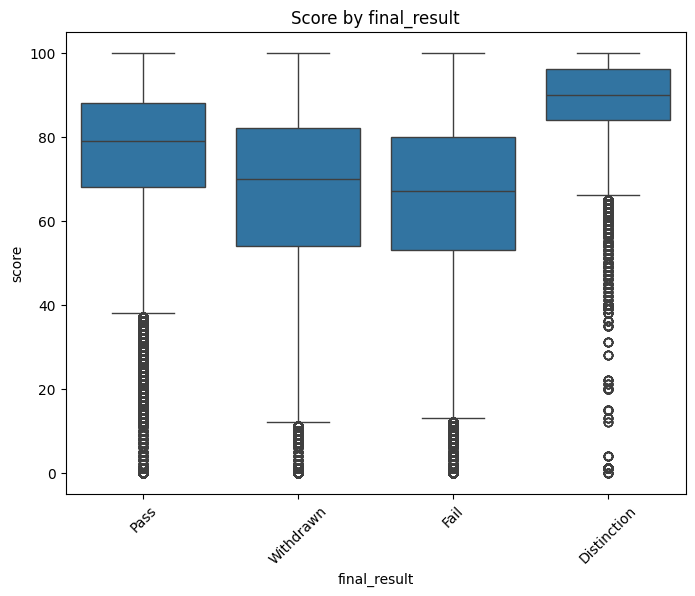

In [60]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='final_result', y='score', data=panda_df)
plt.title('Score by final_result')
plt.xticks(rotation=45)
plt.show()

These levels can be encoded as follows: Fail as 0, Withdrawn as 0, Pass as 1 and Distinction as 2.

In [61]:
# Encode final_result: Fail as 0, Withdrawn as 0, Pass as 1, Distinction as 2
merged_df = merged_df.withColumn(
    'final_result_encoded',
    when(col('final_result') == 'Fail', 0)
    .when(col('final_result') == 'Withdrawn', 0)
    .when(col('final_result') == 'Pass', 1)
    .when(col('final_result') == 'Distinction', 2)
    .otherwise(None)
)

merged_df.select('final_result', 'final_result_encoded').show(5)

+------------+--------------------+
|final_result|final_result_encoded|
+------------+--------------------+
|        Pass|                   1|
|        Pass|                   1|
|        Pass|                   1|
|        Pass|                   1|
|        Pass|                   1|
+------------+--------------------+
only showing top 5 rows



In [62]:
# Drop the 'final_result' column
merged_df = merged_df.drop('final_result')

**Assessment Type:**

---



Calculate the percentage of each assessment type category.

In [63]:
# Calculate the count of each assessment_type category
assessment_type_counts = merged_df.groupBy('assessment_type').count()

assessment_type_counts.show()

+---------------+--------+
|assessment_type|   count|
+---------------+--------+
|           Exam|  879966|
|            TMA|31687426|
|            CMA|24023596|
+---------------+--------+



In [64]:
# Calculate the total number of rows
total_count = merged_df.count()

# Calculate the percentage of each assessment_type category
assessment_type_percentage = assessment_type_counts.withColumn('percentage', (col('count') / total_count) * 100)

assessment_type_percentage.show()

+---------------+--------+------------------+
|assessment_type|   count|        percentage|
+---------------+--------+------------------+
|           Exam|  879966|1.5549578318017703|
|            TMA|31687426| 55.99376706411275|
|            CMA|24023596|42.451275104085475|
+---------------+--------+------------------+



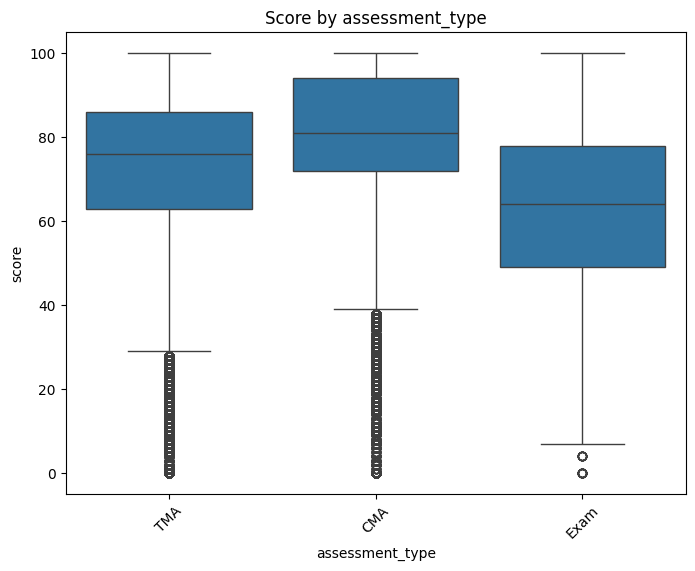

In [65]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='assessment_type', y='score', data=panda_df)
plt.title('Score by assessment_type')
plt.xticks(rotation=45)
plt.show()

Similar to the final result case, observing their relation with the score variable, we can encode assessment type categories as follows: "Exam" as "0", "TMA" as "1" and "CMA" as "2".

In [66]:
# Encode assessment_type: Exam as 0, TMA as 1, CMA as 2
merged_df = merged_df.withColumn(
    'assessment_type_encoded',
    when(col('assessment_type') == 'Exam', 0)
    .when(col('assessment_type') == 'TMA', 1)
    .when(col('assessment_type') == 'CMA', 2)
    .otherwise(None)
)

merged_df.select('assessment_type', 'assessment_type_encoded').show(5)

+---------------+-----------------------+
|assessment_type|assessment_type_encoded|
+---------------+-----------------------+
|            TMA|                      1|
|            TMA|                      1|
|            TMA|                      1|
|            TMA|                      1|
|            TMA|                      1|
+---------------+-----------------------+
only showing top 5 rows



In [67]:
# Drop the 'assessment_type' column
merged_df = merged_df.drop('assessment_type')

**Activity Type:**

---



Calculate the percentage of each assessment type category.

In [68]:
# Calculate the count of each activity_type category
activity_type_counts = merged_df.groupBy('activity_type').count()

activity_type_counts.show()

+--------------+--------+
| activity_type|   count|
+--------------+--------+
|        folder|   24888|
|          quiz| 1168592|
|  ouelluminate|  230663|
|          page| 1176337|
| oucollaborate|  827636|
|      resource|22858481|
|     oucontent| 8062500|
|  htmlactivity|   60992|
|      glossary|  157255|
| questionnaire|  764798|
|           url| 9353489|
|      homepage|  163387|
|        ouwiki|  489684|
|       subpage| 8876169|
|repeatactivity|   76447|
|      dataplus|  269329|
| sharedsubpage|   35177|
|       forumng| 1585475|
|      dualpane|  226447|
|  externalquiz|  183242|
+--------------+--------+



In [69]:
# Calculate the total number of rows
total_count = merged_df.count()

# Calculate the percentage of each activity_type category
activity_type_percentage = activity_type_counts.withColumn('percentage', (col('count') / total_count) * 100)

activity_type_percentage.show()

+--------------+--------+--------------------+
| activity_type|   count|          percentage|
+--------------+--------+--------------------+
|        folder|   24888| 0.04397873385776548|
|          quiz| 1168592|  2.0649789680293265|
|  ouelluminate|  230663|  0.4075967007326325|
|          page| 1176337|  2.0786648927210813|
| oucollaborate|  827636|  1.4624872780097071|
|      resource|22858481|  40.392440223874516|
|     oucontent| 8062500|  14.246968086155343|
|  htmlactivity|   60992| 0.10777687783079526|
|      glossary|  157255|  0.2778799338156104|
| questionnaire|  764798|  1.3514483966952477|
|           url| 9353489|   16.52823060802543|
|      homepage|  163387|  0.2887155813572295|
|        ouwiki|  489684|  0.8653038536807309|
|       subpage| 8876169|  15.684774756008855|
|repeatactivity|   76447| 0.13508687991098514|
|      dataplus|  269329| 0.47592206730866754|
| sharedsubpage|   35177|0.062160073967961124|
|       forumng| 1585475|  2.8016386637391806|
|      dualpa

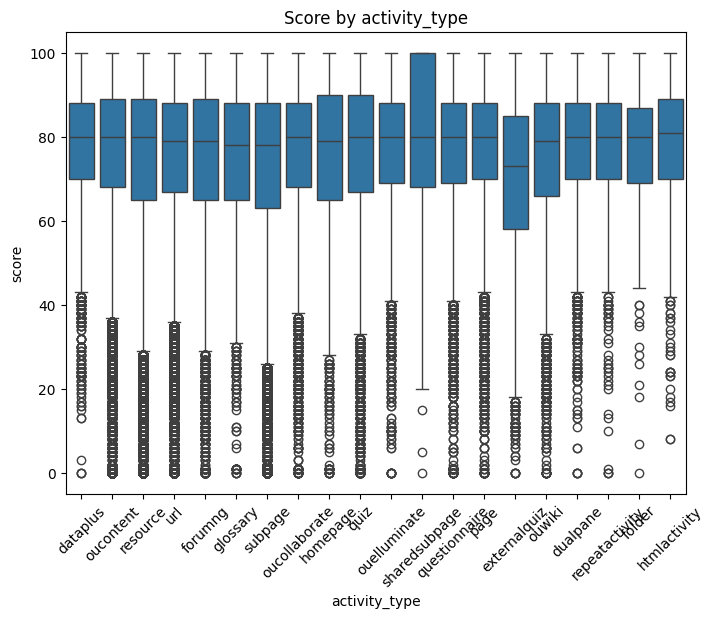

In [70]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='activity_type', y='score', data=panda_df)
plt.title('Score by activity_type')
plt.xticks(rotation=45)
plt.show()

Considering activity type categories, we again observe no significant difference between each levels. Maybe only the external quiz category varies from the others in terms of the score distribution, however it's percentage is too small to take it account. Again we are going to ignore the activity type category as well.

In [71]:
# Drop the 'activity_type' column
merged_df = merged_df.drop('activity_type')

We can also remove many other unnecessary columns that will not contribute to our analysis such as "code_module", "code_presentation", "id_assessment" etc.

In [72]:
# Select the numerical columns which are going to be removed
columns_to_drop = ["code_module", "code_presentation", "id_assessment", "id_student", "num_of_prev_attempts", "is_banked", "date", "id_site", "unregistered"]

# Drop the specified columns
merged_df = merged_df.drop(*columns_to_drop)

In [73]:
merged_df.show()

+--------------+-----+-------------------------+----------------+--------------------+-----------------------+
|date_submitted|score|highest_education_encoded|age_band_encoded|final_result_encoded|assessment_type_encoded|
+--------------+-----+-------------------------+----------------+--------------------+-----------------------+
|           212|   82|                        0|               1|                   1|                      1|
|           212|   82|                        0|               1|                   1|                      1|
|           212|   82|                        0|               1|                   1|                      1|
|           212|   82|                        0|               1|                   1|                      1|
|           212|   82|                        0|               1|                   1|                      1|
|           212|   82|                        0|               1|                   1|                      1|
|

# **Time Series Analysis with 'date_submitted'**



*   **Plot the whole time-series dataset**



We will start with aggregating scores by 'date_submitted', then calculate the mean of each distinct date_submitted value, because there may be many students with the same time step in terms of date_submitted in our dataset. In order to apply time-series analysis, each time step must have a unique value.

Since we may have several score variables for one distinct date_submitted variable, our strategy will be aggregating the date (x-axis) values and calculating each of their averages, so that we can obtain a proper time-series function. And for the categorical variables, we will choose the median value for each distinct date_submitted.

In [74]:
from pyspark.sql.functions import avg, expr

# Group by date_submitted and aggregate the scores and other columns
aggregated_df = merged_df.groupBy("date_submitted").agg(
    avg("score").alias("average_score"),
    expr("percentile_approx(highest_education_encoded, 0.5)").alias("median_highest_education_encoded"),
    expr("percentile_approx(age_band_encoded, 0.5)").alias("median_age_band_encoded"),
    expr("percentile_approx(final_result_encoded, 0.5)").alias("median_final_result_encoded"),
    expr("percentile_approx(assessment_type_encoded, 0.5)").alias("median_assessment_type_encoded")
)

In [75]:
# Number of columns
num_columns = len(aggregated_df.columns)
print(f"Number of columns: {num_columns}")

# Number of rows
num_rows = aggregated_df.count()
print(f"Number of rows: {num_rows}")

Number of columns: 6
Number of rows: 298


In [76]:
aggregated_df.printSchema()

root
 |-- date_submitted: integer (nullable = true)
 |-- average_score: double (nullable = true)
 |-- median_highest_education_encoded: integer (nullable = true)
 |-- median_age_band_encoded: integer (nullable = true)
 |-- median_final_result_encoded: integer (nullable = true)
 |-- median_assessment_type_encoded: integer (nullable = true)



Let's plot the aggregated data.

In [77]:
# Collect the results for plotting
aggregated_data = aggregated_df.orderBy("date_submitted").collect()

In [78]:
# Extracting values for plotting
dates = [row['date_submitted'] for row in aggregated_data]
scores = [row['average_score'] for row in aggregated_data]

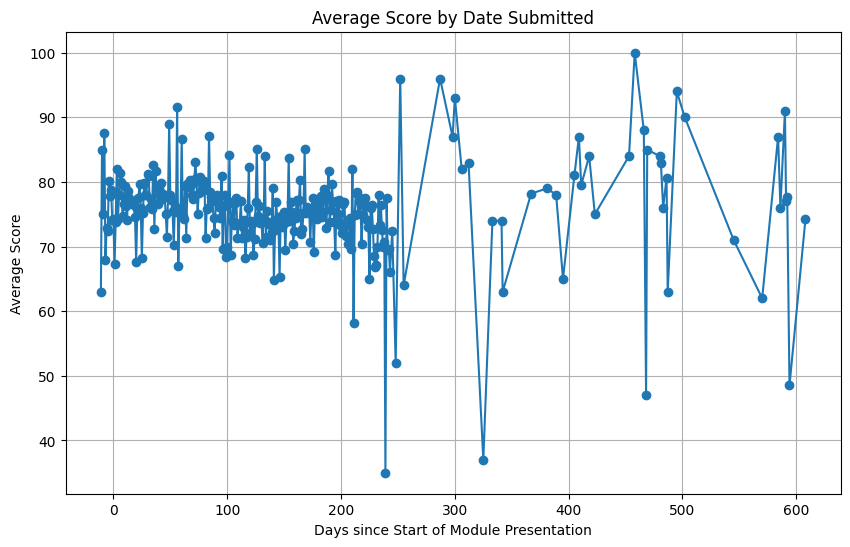

In [79]:
# Plot the aggregated data
plt.figure(figsize=(10, 6))
plt.plot(dates, scores, marker='o')
plt.title('Average Score by Date Submitted')
plt.xlabel('Days since Start of Module Presentation')
plt.ylabel('Average Score')
plt.grid(True)
plt.show()

## Data Preparation and Pre-Processing

As we can see from the plot, there is a huge gap between each consecutive date values after around 210. therefore we decided to continue our analysis with the first 210 values.

Filter data to the first 210 days:

In [80]:
# Filter the data to include only rows where date_submitted is greater than 0 and less than or equal to 210
aggregated_df = aggregated_df.filter((col("date_submitted") > 0) & (col("date_submitted") <= 210))

**Plotting the graph**

---



After filtering to 210 rows, the aggregated_data has to be updated as well.

In [81]:
# Collect the results for plotting
aggregated_data = aggregated_df.orderBy("date_submitted").collect()

In [82]:
# Extracting values for plotting
dates = [row['date_submitted'] for row in aggregated_data]
scores = [row['average_score'] for row in aggregated_data]

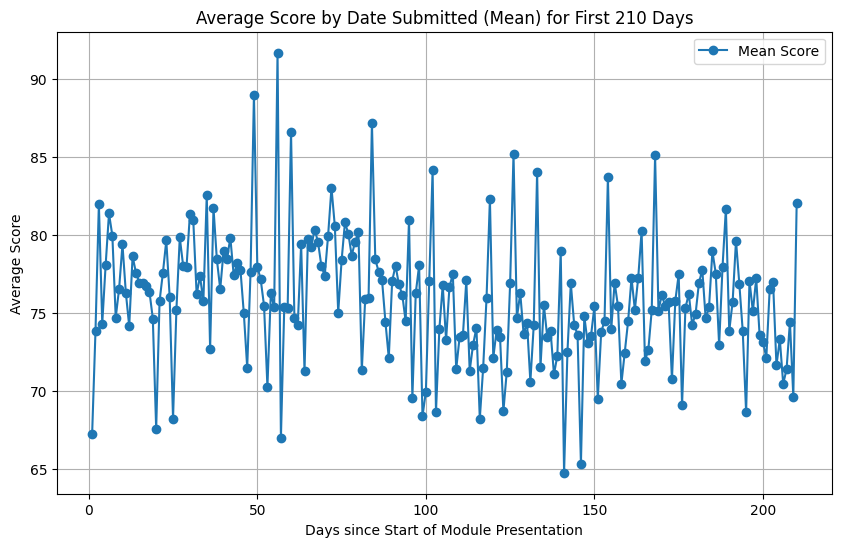

In [83]:
# Plot the aggregated data (Mean) for the first 210 days
plt.figure(figsize=(10, 6))
plt.plot(dates, scores, marker='o', label='Mean Score')
plt.title('Average Score by Date Submitted (Mean) for First 210 Days')
plt.xlabel('Days since Start of Module Presentation')
plt.ylabel('Average Score')
plt.grid(True)
plt.legend()
plt.show()

**Data Cleaning**

---





Check if there are any missing values.

In [84]:
# Verify no missing values
aggregated_df.select([count(when(col(c).isNull(), c)).alias(c) for c in aggregated_df.columns]).show()

+--------------+-------------+--------------------------------+-----------------------+---------------------------+------------------------------+
|date_submitted|average_score|median_highest_education_encoded|median_age_band_encoded|median_final_result_encoded|median_assessment_type_encoded|
+--------------+-------------+--------------------------------+-----------------------+---------------------------+------------------------------+
|             0|            0|                               0|                      0|                          0|                             0|
+--------------+-------------+--------------------------------+-----------------------+---------------------------+------------------------------+



Since there seems no missing values in both x and y-axis we don't need to apply any filling method.

From now on, we convert our Spark Dataframe 'aggregated_df' to Pandas dataframe 'aggregated_pd', since the methods and functions we are going to apply for time series analysis are more simplified in pandas library.

In [85]:
# Convert the aggregated Spark DataFrame to a Pandas DataFrame
aggregated_pd = pd.DataFrame(aggregated_data, columns=['date_submitted', 'average_score', 'highest_education_encoded', 'age_band_encoded', 'final_result_encoded', 'assessment_type_encoded'])

In [86]:
# Extract the time series data for 'average_score'
ts_data = aggregated_pd['average_score']

print(aggregated_pd.head())

   date_submitted  average_score  highest_education_encoded  age_band_encoded  \
0               1      67.237769                          0                 0   
1               2      73.871230                          0                 0   
2               3      81.970014                          0                 0   
3               4      74.314934                          0                 0   
4               5      78.040434                          0                 0   

   final_result_encoded  assessment_type_encoded  
0                     1                        1  
1                     1                        1  
2                     1                        2  
3                     1                        2  
4                     1                        2  


**Anomaly Detection**

---





In [87]:
# Create a copy of the aggregated_pd
copied_df = aggregated_pd

We will apply the Isolation Forest algorithm to detect anomalies in the average_score.

In [88]:
# Extract the average_score column as a numpy array for anomaly detection
scores = copied_df['average_score'].values.reshape(-1, 1)

In [89]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05)

In [90]:
# Fit the model
iso_forest.fit(scores)

IsolationForest(contamination=0.05)

In [91]:
# Predict anomalies (1 for normal, -1 for anomaly)
predictions = iso_forest.predict(scores)

In [92]:
# Add the predictions to the dataframe
copied_df['anomaly'] = predictions

In [93]:
# Filter out the anomalies
anomalies = copied_df[copied_df['anomaly'] == -1]

# Display the anomalies
print(anomalies)

     date_submitted  average_score  highest_education_encoded  \
0                 1      67.237769                          0   
19               20      67.579769                          0   
48               49      88.978733                          0   
55               56      91.652505                          0   
56               57      66.973203                          0   
59               60      86.602879                          0   
83               84      87.146257                          0   
125             126      85.171406                          0   
140             141      64.774799                          0   
145             146      65.355614                          0   
167             168      85.082763                          0   

     age_band_encoded  final_result_encoded  assessment_type_encoded  anomaly  
0                   0                     1                        1       -1  
19                  0                     1                

Now that we have 11 anormal values, it would be better to remove them for a better prediction later. However, there will be missing values after removing these anomalities. To fill those missing values due to anomaly, we will apply forward filling method.

**Decomposition**

---




A better and healthier conclusion can be made about the time series plot when we decompose into it's trend, seasonality and residual components.

<Figure size 1400x700 with 0 Axes>

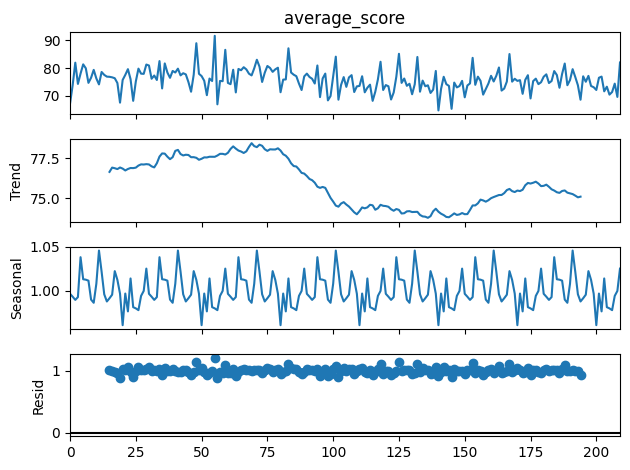

In [94]:
decomposition = seasonal_decompose(ts_data, model='multiplicative', period=30)
plt.figure(figsize=(14, 7))
decomposition.plot()
plt.show()

It is obvious from the trend graph that the series is not stationary, however it should be checked by the ADF and KPSS tests as well.

**Stationarity Tests**

---



In [95]:
adf_test = adfuller(ts_data)
kpss_test = kpss(ts_data)

print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('KPSS Statistic:', kpss_test[0])
print('p-value:', kpss_test[1])

ADF Statistic: -2.3294888340210256
p-value: 0.16263351637135376
KPSS Statistic: 1.3487167505663986
p-value: 0.01


The results provided are from two different statistical tests used to check for stationarity in a time series: the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. Here’s what these results indicate:

1. **Augmented Dickey-Fuller (ADF) Test**:
   - **ADF Statistic**: -2.3384862557356727
   - **p-value**: 0.16

   The ADF test checks the null hypothesis that a unit root is present in the time series (i.e., the time series is non-stationary).

   - **Interpretation**: A common threshold for the p-value is 0.05. Since the p-value (0.1599) is greater than 0.05, we fail to reject the null hypothesis. This suggests that there is not enough evidence to conclude that the time series is stationary. In other words, the time series is likely non-stationary.

2. **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test**:
   - **KPSS Statistic**: 1.2712955217804964
   - **p-value**: 0.01

   The KPSS test checks the null hypothesis that the time series is stationary around a deterministic trend.

   - **Interpretation**: For the KPSS test, a common threshold for the p-value is also 0.05. Since the p-value (0.01) is less than 0.05, we reject the null hypothesis. This indicates that the time series is not stationary around a deterministic trend.

**Conclusion**:
The results from both tests suggest that the time series is non-stationary. Specifically:
- The ADF test indicates that the series likely has a unit root (non-stationary).
- The KPSS test indicates that the series is not stationary around a deterministic trend.

Both tests together provide strong evidence that the time series is non-stationary, and it may need differencing or other transformations to achieve stationarity.

**Making Stationary with Differencing Method**

---



Differencing is a common method to make a time series stationary. We will apply the first-order differencing to remove the trend component.

In [96]:
# Perform first-order differencing
copied_df['average_score_diff1'] = copied_df['average_score'].diff().dropna()

In [97]:
# Drop NaN values resulting from differencing
diff_series = copied_df['average_score_diff1'].dropna()

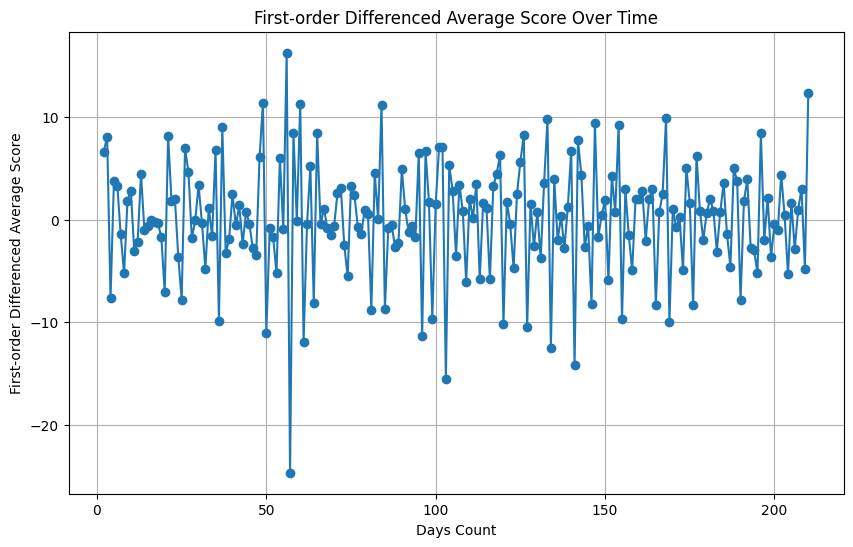

In [98]:
# Plot the first-order differenced series
plt.figure(figsize=(10, 6))
plt.plot(copied_df['date_submitted'][1:], diff_series, marker='o', linestyle='-')
plt.title('First-order Differenced Average Score Over Time')
plt.xlabel('Days Count')
plt.ylabel('First-order Differenced Average Score')
plt.grid(True)
plt.show()

In [99]:
# Check the first few rows to confirm the differencing worked correctly
print(diff_series.head())

1    6.633461
2    8.098784
3   -7.655080
4    3.725500
5    3.329173
Name: average_score_diff1, dtype: float64


When we removed trend, the plot seems much more stationary now. Let's check for the stationarity again by applying ADF and KPSS tests.

In [100]:
# Function to perform the ADF test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    return result

# Function to perform the KPSS test
def kpss_test(series):
    result = kpss(series, regression='c', nlags="auto")
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[3])
    return result

# Apply the ADF test on the first-order differenced series
print("ADF Test Results on First-order Differenced Series:")
adf_result_diff1 = adf_test(diff_series)

# Apply the KPSS test on the first-order differenced series
print("\nKPSS Test Results on First-order Differenced Series:")
kpss_result_diff1 = kpss_test(diff_series)

ADF Test Results on First-order Differenced Series:
ADF Statistic: -15.422184917614338
p-value: 3.0243845421325854e-28
Critical Values: {'1%': -3.462980134086401, '5%': -2.875885461947131, '10%': -2.5744164898444515}

KPSS Test Results on First-order Differenced Series:
KPSS Statistic: 0.16554997286472373
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Both test results indicate that our time-series is stationary after applying first order differencing. Now we may start with appropriate model creation.

## Forecasting

**Split the Dataset**

---



Since our series include seasional component, and since we are going to consider other categorical variables also in our analysis, the most appropriate model would be SARIMAX in our case.

In [101]:
from sklearn.model_selection import train_test_split

# Split the processed dataframe (copied_df) into training and test sets
train, test = train_test_split(copied_df, test_size=0.2, shuffle=False)

**Plot ACF and PACF**

---



We will plot the Auto-Correlation Function (ACF) and Partial Auto-Correlation Function (PACF) to identify the order of the AR and MA components.

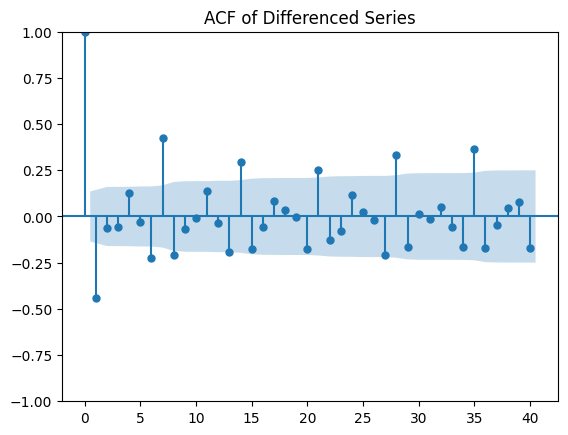

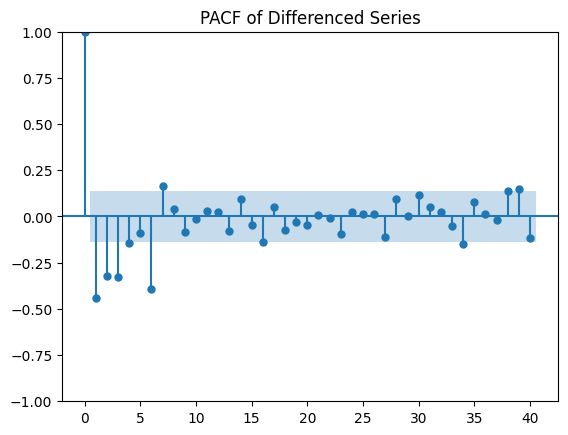

In [102]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plot_acf(diff_series, lags=40)
plt.title('ACF of Differenced Series')
plt.show()

# Plot PACF
plot_pacf(diff_series, lags=40)
plt.title('PACF of Differenced Series')
plt.show()

AR Component (p): Since there is a significant spike at lag 1 in the PACF, it suggests an AR component. An AR(1) model might be a good starting point.


MA Component (q): The ACF plot also shows a significant spike at lag 1, which might suggest an MA component. An MA(1) model might also be a good starting point.

Differencing (d): Given that we have performed first-order differencing to make the series stationary, we have
𝑑
=
1.

We should also plot ACF and PACF for the seasonal component in order to determine their degrees.

<Figure size 1000x600 with 0 Axes>

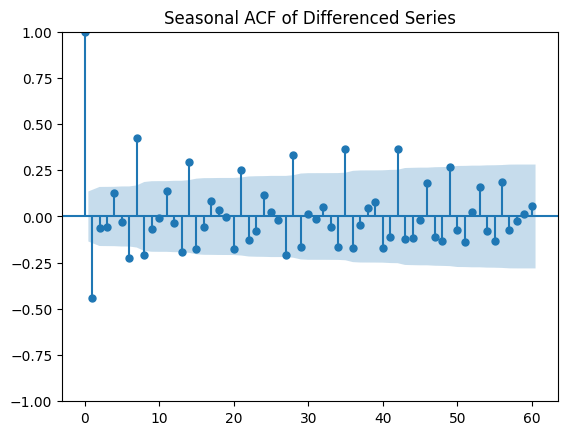

<Figure size 1000x600 with 0 Axes>

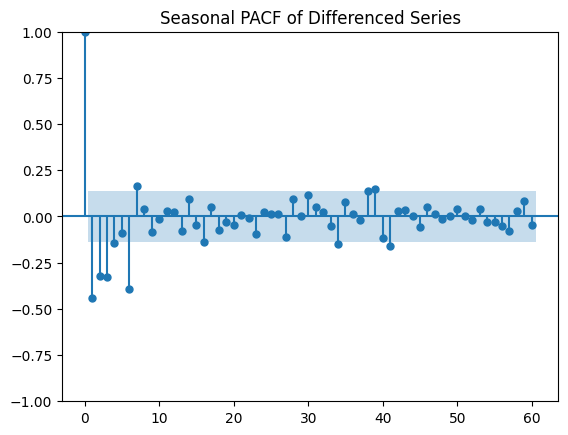

In [103]:
# Assuming the seasonal period is 30
seasonal_period = 30

# Plot seasonal ACF
plt.figure(figsize=(10, 6))
plot_acf(diff_series, lags=seasonal_period * 2)
plt.title('Seasonal ACF of Differenced Series')
plt.show()

# Plot seasonal PACF
plt.figure(figsize=(10, 6))
plot_pacf(diff_series, lags=seasonal_period * 2)
plt.title('Seasonal PACF of Differenced Series')
plt.show()

Based on the seasonal ACF and PACF plots, we might consider:

*   Seasonal AR (P): 1
*   Seasonal MA (Q): 1
*   Seasonal Differencing (D): 1 (as we have already differenced once)
*   Seasonal Period (S): 30

## SARIMAX Model

In [104]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

**Define the SARIMAX model**

---



In [105]:
# Define the SARIMAX model
model = SARIMAX(
    train['average_score'],
    exog=train[['age_band_encoded', 'highest_education_encoded', 'assessment_type_encoded']],
    order=(2, 1, 2),  # Based on general ACF/PACF
    seasonal_order=(2, 1, 2, 30)  # Based on seasonal ACF/PACF
)

**Fit the model**

---



In [106]:
# Fit the model
sarimax_model = model.fit()

In [107]:
# Summary of the model
print(sarimax_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      average_score   No. Observations:                  168
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 30)   Log Likelihood                -401.992
Date:                            Tue, 18 Jun 2024   AIC                            827.984
Time:                                    08:54:29   BIC                            863.023
Sample:                                         0   HQIC                           842.223
                                            - 168                                         
Covariance Type:                              opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
age_band_encoded                   0    282.084          0      1.000    -552.874   

**Prediction**

---



In [108]:
# Forecast the values
forecast = sarimax_model.get_forecast(steps=len(test), exog=test[['age_band_encoded','highest_education_encoded', 'assessment_type_encoded']])

In [109]:
# Extract the predicted mean values
forecasted_values = forecast.predicted_mean

**Plot the forecasted values against the actual values**

---



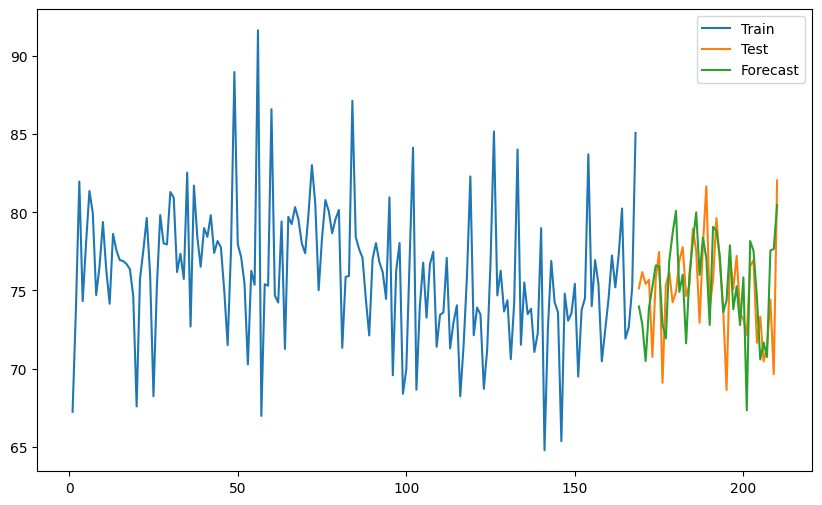

In [110]:
# Plot the forecasted values against the actual values
plt.figure(figsize=(10, 6))
plt.plot(train['date_submitted'], train['average_score'], label='Train')
plt.plot(test['date_submitted'], test['average_score'], label='Test')
plt.plot(test['date_submitted'], forecasted_values, label='Forecast')
plt.legend()
plt.show()

**Evaluation**

---



In [111]:
# Evaluate the model
mse = mean_squared_error(test['average_score'], forecasted_values)
mae = mean_absolute_error(test['average_score'], forecasted_values)
rmse = mse ** 0.5

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MSE: 8.77902497742197
MAE: 2.3829297012094
RMSE: 2.9629419463469024


## LSTM Model

**Preprocess the Data**

---



In [112]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Prepare the data for RNN model
SEQ_LENGTH = 30  # Assuming a sequence length of 30

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(copied_df[['average_score', 'highest_education_encoded', 'age_band_encoded', 'final_result_encoded', 'assessment_type_encoded']])

In [113]:
# Split the data into training and test sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [114]:
# Function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length, 0]
        sequences.append((seq, target))
    return sequences

# Create sequences
train_sequences = create_sequences(train_data, SEQ_LENGTH)
test_sequences = create_sequences(test_data, SEQ_LENGTH)

In [115]:
# Split sequences into features and targets
X_train, y_train = zip(*train_sequences)
X_test, y_test = zip(*test_sequences)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

**Build the LSTM Model**

---



In [116]:
# Build the LSTM model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

In [117]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           42400     
                                                                 
 dropout (Dropout)           (None, 30, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 72651 (283.79 KB)
Trainable params: 72651 (283.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Train the Model**

---



In [118]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
5/5 [==============================] - 2s 90ms/step - loss: 0.1630 - val_loss: 0.0419
Epoch 2/50
5/5 [==============================] - 0s 29ms/step - loss: 0.0545 - val_loss: 0.0487
Epoch 3/50
5/5 [==============================] - 0s 26ms/step - loss: 0.0495 - val_loss: 0.0216
Epoch 4/50
5/5 [==============================] - 0s 25ms/step - loss: 0.0305 - val_loss: 0.0151
Epoch 5/50
5/5 [==============================] - 0s 28ms/step - loss: 0.0390 - val_loss: 0.0160
Epoch 6/50
5/5 [==============================] - 0s 24ms/step - loss: 0.0307 - val_loss: 0.0250
Epoch 7/50
5/5 [==============================] - 0s 23ms/step - loss: 0.0286 - val_loss: 0.0257
Epoch 8/50
5/5 [==============================] - 0s 24ms/step - loss: 0.0325 - val_loss: 0.0216
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 0.0279 - val_loss: 0.0171
Epoch 10/50
5/5 [==============================] - 0s 28ms/step - loss: 0.0333 - val_loss: 0.0188
Epoch 11/50
5/5 [============

**Predictions**

---



In [119]:
# Make predictions
predictions = model.predict(X_test)

1/1 [==============================] - 0s 235ms/step


In [122]:
# Rescale predictions and actual values
predictions_rescaled = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]

In [123]:
# Rescale the entire dataset
rescaled_data = scaler.inverse_transform(scaled_data)

# Extract the dates for the entire dataset
dates = copied_df['date_submitted']

# Split the rescaled data into training and test sets
train_rescaled = rescaled_data[:train_size + SEQ_LENGTH]
test_rescaled = rescaled_data[train_size + SEQ_LENGTH:]

**Plot the result**

---



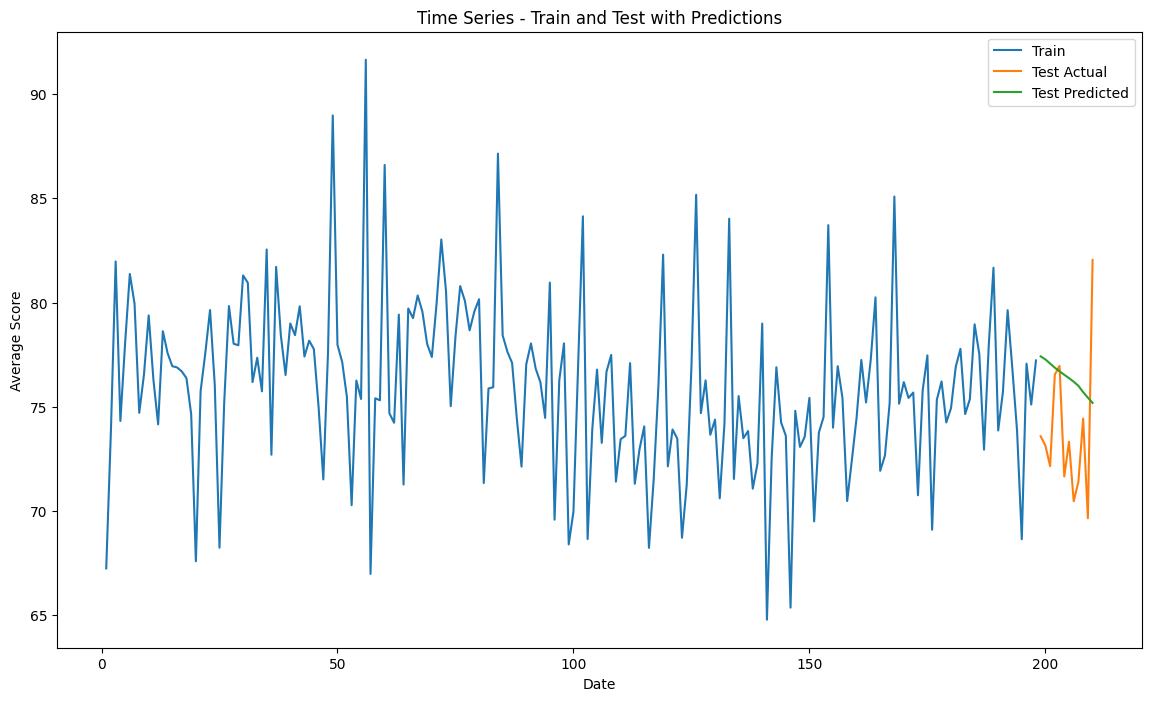

In [124]:
# Plot the entire time series
plt.figure(figsize=(14, 8))
plt.plot(dates[:train_size + SEQ_LENGTH], train_rescaled[:, 0], label='Train')
plt.plot(dates[train_size + SEQ_LENGTH:], y_test_rescaled, label='Test Actual')
plt.plot(dates[train_size + SEQ_LENGTH:], predictions_rescaled, label='Test Predicted')
plt.xlabel('Date')
plt.ylabel('Average Score')
plt.legend()
plt.title('Time Series - Train and Test with Predictions')
plt.show()

**Evaluation**

---



In [125]:
# Evaluate the model
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MSE: 18.80249074387825
MAE: 3.806695279780777
RMSE: 4.336183891842947
